## Compare dim vs non-dim models

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
import sys
sys.path.append('../modules/')

In [3]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-02-03 18:51:02.615130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-03 18:51:02.633341: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-03 18:51:02.638860: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
experiment_config_nondim = {'experiment_name': 'DG_3_non_dim', # Any sort of name will work here 
                    'simulation_names':['DG'], 
                    'filter_scales':['50','100','200','400'],
                    'window_size':3, 
                    
                    'input_channels' : ['dudx_widened_nondim',  
                                        'dvdx_widened_nondim', 
                                        'dudy_widened_nondim',
                                        'dvdy_widened_nondim',
                                        'dhdx_widened_nondim',
                                        'dhdy_widened_nondim'],
                    
                    'output_channels' : ['uphp_nondim',
                                         'vphp_nondim'],
                    
                    'coeff_channels'  : [], 
                    
                    'extra_channels': ['filter_scale',
                                       'mag_nabla_u_widened',
                                       'uphp',
                                       'vphp'],

                    'all_time_range': slice(0, 1400), 
                    'train_time_range': slice(0, 1200),
                    'test_time_range' : slice(-100, None),
                    'num_train_batches': 37, 
                    'num_test_batches' : 5, 
                   
                    'network_shape': [36, 36, 2],
                    'single_layer_mask': True}

experiment_config_nondim['all_ml_variables'] = (experiment_config_nondim['input_channels'] + 
                                           experiment_config_nondim['output_channels'] +
                                           experiment_config_nondim['coeff_channels']+ 
                                           experiment_config_nondim['extra_channels'])

experiment_config_nondim['exp_ckpt_save_dir'] = ('/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/non_dim_models/' + 
                                          experiment_config_nondim['experiment_name'] ) 

In [5]:
experiment_config_dim = {'experiment_name': 'DG_3_dim', # Any sort of name will work here 
                    'simulation_names':['DG'], 
                    'filter_scales':['50','100','200','400'],
                    'window_size':3, 
                    
                    'input_channels' : ['dudx_widened',  
                                        'dvdx_widened', 
                                        'dudy_widened',
                                        'dvdy_widened',
                                        'dhdx_widened',
                                        'dhdy_widened',
                                        'filter_scale'],
                    
                    'output_channels' : ['uphp',
                                         'vphp'],
                    
                    'coeff_channels'  : [], 
                    
                    'extra_channels': [],

                    'all_time_range': slice(0, 1400), 
                    'train_time_range': slice(0, 1200),
                    'test_time_range' : slice(-100, None),
                    'num_train_batches': 37, 
                    'num_test_batches' : 5, 
                   
                    'network_shape': [36, 36, 2],
                    'single_layer_mask': True}

experiment_config_dim['all_ml_variables'] = (experiment_config_dim['input_channels'] + 
                                           experiment_config_dim['output_channels'] +
                                           experiment_config_dim['coeff_channels']+ 
                                           experiment_config_dim['extra_channels'])

experiment_config_dim['exp_ckpt_save_dir'] = ('/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/dim_models/' + 
                                          experiment_config_dim['experiment_name'] ) 

In [6]:
experiment_config_dim['num_inputs'] = 55
experiment_config_nondim['num_inputs'] = 54

In [9]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=experiment_config_nondim['simulation_names'], 
                             filter_scales=experiment_config_nondim['filter_scales'], 
                             window_size = experiment_config_nondim['window_size'],
                             time_sel = experiment_config_nondim['all_time_range'],
                             single_layer_mask_flag=experiment_config_nondim['single_layer_mask'])

## Training

In [10]:
ML_DT_train_nondim = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=experiment_config_nondim['all_ml_variables'],
                                       time_range=experiment_config_nondim['train_time_range'],
                                       num_batches = experiment_config_nondim['num_train_batches'])

ML_DT_test_nondim = datasets.MLXarrayDataset(simulation_data=DT,
                                      all_ml_variables=experiment_config_nondim['all_ml_variables'],
                                      time_range=experiment_config_nondim['test_time_range'],
                                      num_batches = experiment_config_nondim['num_test_batches'])

Will load : 3.28704 gb into memory.
load took: 58.5028 seconds
Will load : 0.27392 gb into memory.
load took: 6.2004 seconds


In [11]:
ML_DT_train_dim = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=experiment_config_dim['all_ml_variables'],
                                       time_range=experiment_config_dim['train_time_range'],
                                       num_batches = experiment_config_dim['num_train_batches'])

ML_DT_test_dim = datasets.MLXarrayDataset(simulation_data=DT,
                                      all_ml_variables=experiment_config_dim['all_ml_variables'],
                                      time_range=experiment_config_dim['test_time_range'],
                                      num_batches = experiment_config_dim['num_test_batches'])

Will load : 3.13296 gb into memory.
load took: 33.5149 seconds
Will load : 0.26108 gb into memory.
load took: 3.2498 seconds


In [10]:
normalize_data_dic={
    'dudx_widened_nondim': ([], 1.),  # scalar value
    'dvdx_widened_nondim': ([], 1.),
    'dudy_widened_nondim': ([], 1.),
    'dvdy_widened_nondim': ([], 1.),

    'dhdx_widened': ([], 1e-4),
    'dhdy_widened': ([], 1e-4),

    'dudx_widened': ([], 1e-7),  # scalar value
    'dvdx_widened': ([], 1e-7),
    'dudy_widened': ([], 1e-7),
    'dvdy_widened': ([], 1e-7),

    'Rd_nondim': ([], 1.),
    'filter_scale': ([], 140e3),
    
    'uphp_nondim': ([], 1e-5),
    'vphp_nondim': ([], 1e-5),
    'uphp': ([], .4),
    'vphp': ([], .4)}

ds_norm = xr.Dataset(normalize_data_dic)

In [11]:
train_ML_data_dim = datasets.MLJAXDataset(ML_DT_train_dim, 
                                      input_channels=experiment_config_dim['input_channels'], 
                                      output_channels=experiment_config_dim['output_channels'], 
                                      coeff_channels=experiment_config_dim['coeff_channels'], 
                                      ds_norm=ds_norm)

test_ML_data_dim = datasets.MLJAXDataset(ML_DT_test_dim, 
                                      input_channels=experiment_config_dim['input_channels'], 
                                      output_channels=experiment_config_dim['output_channels'], 
                                      coeff_channels=experiment_config_dim['coeff_channels'],
                                      ds_norm=ds_norm)

ML_data_combo_dim = {'train_data':train_ML_data_dim, 'test_data':test_ML_data_dim}

In [12]:
train_ML_data_nondim = datasets.MLJAXDataset(ML_DT_train_nondim, 
                                      input_channels=experiment_config_nondim['input_channels'], 
                                      output_channels=experiment_config_nondim['output_channels'], 
                                      coeff_channels=experiment_config_nondim['coeff_channels'], 
                                      ds_norm=ds_norm)

test_ML_data_nondim = datasets.MLJAXDataset(ML_DT_test_nondim, 
                                      input_channels=experiment_config_nondim['input_channels'], 
                                      output_channels=experiment_config_nondim['output_channels'], 
                                      coeff_channels=experiment_config_nondim['coeff_channels'],
                                      ds_norm=ds_norm)

ML_data_combo_nondim = {'train_data':train_ML_data_nondim, 'test_data':test_ML_data_nondim}

In [15]:
ANN_model_nondim = ML_classes.PointwiseANN(num_in = experiment_config_nondim['num_inputs'],
                                    shape = experiment_config_nondim['network_shape']) 

In [16]:
ANN_model_nondim.count_parameters()

3386


In [17]:
regress_sys_nondim = ML_classes.AnnRegressionSystem(ANN_model_nondim)

In [18]:
%%time 
regress_sys_nondim.train_system(ML_data_combo_nondim, num_epoch=101, print_freq=2, use_wandb=False)

At epoch 1. Train loss :  0.8676958696262257 , Test loss: 0.6316290378570557
At epoch 3. Train loss :  0.38774993935146845 , Test loss: 0.37880821228027345
At epoch 5. Train loss :  0.31730327896169713 , Test loss: 0.32264333963394165
At epoch 7. Train loss :  0.28726456374735443 , Test loss: 0.2960302889347076
At epoch 9. Train loss :  0.2706749825864225 , Test loss: 0.28070473074913027
At epoch 11. Train loss :  0.2587275891690641 , Test loss: 0.2748046815395355
At epoch 13. Train loss :  0.25039456623631556 , Test loss: 0.26094112992286683
At epoch 15. Train loss :  0.2441143176040134 , Test loss: 0.2538028538227081
At epoch 17. Train loss :  0.23818437835654696 , Test loss: 0.24952543675899505
At epoch 19. Train loss :  0.23300513504324732 , Test loss: 0.24459663033485413
At epoch 21. Train loss :  0.22908013938246546 , Test loss: 0.24001677632331847
At epoch 23. Train loss :  0.22334929656338048 , Test loss: 0.2357926160097122
At epoch 25. Train loss :  0.2190758751050846 , Test l

In [19]:
ANN_model_dim = ML_classes.PointwiseANN(num_in = experiment_config_dim['num_inputs'],
                                    shape = experiment_config_dim['network_shape']) 

regress_sys_dim = ML_classes.AnnRegressionSystem(ANN_model_dim)

In [20]:
%%time 
regress_sys_dim.train_system(ML_data_combo_dim, num_epoch=101, print_freq=2, use_wandb=False)

At epoch 1. Train loss :  1.6603907540037826 , Test loss: 1.1225838661193848
At epoch 3. Train loss :  0.8567921374295209 , Test loss: 0.8489752411842346
At epoch 5. Train loss :  0.7118496041040163 , Test loss: 0.7328644752502441
At epoch 7. Train loss :  0.6377104971859906 , Test loss: 0.66423020362854
At epoch 9. Train loss :  0.6023015943733422 , Test loss: 0.6343042969703674
At epoch 11. Train loss :  0.5495183806161623 , Test loss: 0.5980721950531006
At epoch 13. Train loss :  0.5093683680972537 , Test loss: 0.5353681683540344
At epoch 15. Train loss :  0.48609203744579005 , Test loss: 0.5325471043586731
At epoch 17. Train loss :  0.46115742664079407 , Test loss: 0.5398152351379395
At epoch 19. Train loss :  0.4390483176386034 , Test loss: 0.4771028995513916
At epoch 21. Train loss :  0.42860249570898107 , Test loss: 0.45820496082305906
At epoch 23. Train loss :  0.41278267148378733 , Test loss: 0.47429954409599306
At epoch 25. Train loss :  0.4027280815549799 , Test loss: 0.4588

In [21]:
experiment_config_nondim['exp_ckpt_save_dir']

'/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/non_dim_models/DG_3_non_dim'

In [22]:
regress_sys_nondim.save_checkpoint(experiment_config_nondim['exp_ckpt_save_dir'], overwrite=True)
regress_sys_dim.save_checkpoint(experiment_config_dim['exp_ckpt_save_dir'])

In [23]:
test_eval_nondim = evaluation.EvalSystem(simulation_data=DT,
                                 input_channels=experiment_config_nondim['input_channels'],
                                 output_channels=experiment_config_nondim['output_channels'], 
                                 coeff_channels=experiment_config_nondim['coeff_channels'], 
                                 extra_channels=experiment_config_nondim['extra_channels'], 
                                 ds_norm_factors=ds_norm,
                                 eval_time_slice=slice(1000, 1010), 
                                 num_inputs=experiment_config_nondim['num_inputs'], 
                                 shape=experiment_config_nondim['network_shape'], 
                                 ckpt_dir=experiment_config_nondim['exp_ckpt_save_dir'])

# Spin up eval pack
test_eval_nondim.read_ann_regression_model()
test_eval_nondim.read_eval_data()
test_eval_nondim.predict()

In [24]:
test_eval_nondim.dimensionalize()

In [25]:
test_eval_dim = evaluation.EvalSystem(simulation_data=DT,
                                 input_channels=experiment_config_dim['input_channels'],
                                 output_channels=experiment_config_dim['output_channels'], 
                                 coeff_channels=experiment_config_dim['coeff_channels'], 
                                 extra_channels=experiment_config_dim['extra_channels'], 
                                 ds_norm_factors=ds_norm,
                                 eval_time_slice=slice(1000, 1010), 
                                 num_inputs=experiment_config_dim['num_inputs'], 
                                 shape=experiment_config_dim['network_shape'], 
                                 ckpt_dir=experiment_config_dim['exp_ckpt_save_dir'])

# Spin up eval pack
test_eval_dim.read_ann_regression_model()
test_eval_dim.read_eval_data()
test_eval_dim.predict()

In [36]:
test_eval_dim.calc_time_hor_space_metrics(var='uphp', yh_region=slice(31, 50),descriptor='layer_wise', dims=['Time','xh','yh'])
test_eval_dim.calc_time_hor_space_metrics(var='vphp', yh_region=slice(31, 50), descriptor='layer_wise', dims=['Time','xh','yh'])


test_eval_dim.calc_time_hor_space_metrics(var='uphp', descriptor='time', dims=['Time'])
test_eval_dim.calc_time_hor_space_metrics(var='vphp', descriptor='time', dims=['Time'])

In [37]:
test_eval_nondim.calc_time_hor_space_metrics(var='uphp', yh_region=slice(31, 50),descriptor='layer_wise', dims=['Time','xh','yh'])
test_eval_nondim.calc_time_hor_space_metrics(var='vphp', yh_region=slice(31, 50), descriptor='layer_wise', dims=['Time','xh','yh'])


test_eval_nondim.calc_time_hor_space_metrics(var='uphp', descriptor='time', dims=['Time'])
test_eval_nondim.calc_time_hor_space_metrics(var='vphp', descriptor='time', dims=['Time'])

In [35]:
test_eval_nondim.calc_time_hor_space_metrics(var='uphp_nondim', yh_region=slice(31, 50),descriptor='layer_wise', dims=['Time','xh','yh'])
test_eval_nondim.calc_time_hor_space_metrics(var='vphp_nondim', yh_region=slice(31, 50), descriptor='layer_wise', dims=['Time','xh','yh'])


test_eval_nondim.calc_time_hor_space_metrics(var='uphp_nondim', descriptor='time', dims=['Time'])
test_eval_nondim.calc_time_hor_space_metrics(var='vphp_nondim', descriptor='time', dims=['Time'])

In [38]:
for exp in experiment_config_nondim['simulation_names']: 
    for scale in experiment_config_nondim['filter_scales']: 
        print(exp+' '+scale+'km, R2 for uphp nondim is (layer:[0,1])'+ str(test_eval_nondim.eval_datatree.ml_dataset[exp][scale].uphp_nondim_R2_layer_wise.values))
        print(exp+' '+scale+'km, R2 for vphp nondim is (layer:[0,1])'+ str(test_eval_nondim.eval_datatree.ml_dataset[exp][scale].vphp_nondim_R2_layer_wise.values))

DG 50km, R2 for uphp nondim is (layer:[0,1])[0.95040316 0.94482331]
DG 50km, R2 for vphp nondim is (layer:[0,1])[0.96159005 0.94315012]
DG 100km, R2 for uphp nondim is (layer:[0,1])[0.91468589 0.89785958]
DG 100km, R2 for vphp nondim is (layer:[0,1])[0.92922098 0.89360068]
DG 200km, R2 for uphp nondim is (layer:[0,1])[0.8035497  0.68675631]
DG 200km, R2 for vphp nondim is (layer:[0,1])[0.74375315 0.73102596]
DG 400km, R2 for uphp nondim is (layer:[0,1])[0.66250884 0.47381575]
DG 400km, R2 for vphp nondim is (layer:[0,1])[0.51085216 0.56822488]


In [39]:
for exp in experiment_config_nondim['simulation_names']: 
    for scale in experiment_config_nondim['filter_scales']: 
        print(exp+' '+scale+'km, R2 for uphp is (layer:[0,1])'+ str(test_eval_nondim.eval_datatree.ml_dataset[exp][scale].uphp_R2_layer_wise.values))
        print(exp+' '+scale+'km, R2 for vphp is (layer:[0,1])'+ str(test_eval_nondim.eval_datatree.ml_dataset[exp][scale].vphp_R2_layer_wise.values))

DG 50km, R2 for uphp is (layer:[0,1])[0.94584011 0.9480455 ]
DG 50km, R2 for vphp is (layer:[0,1])[0.96700051 0.94532711]
DG 100km, R2 for uphp is (layer:[0,1])[0.91402849 0.90145053]
DG 100km, R2 for vphp is (layer:[0,1])[0.93424724 0.90781729]
DG 200km, R2 for uphp is (layer:[0,1])[0.81215319 0.73313983]
DG 200km, R2 for vphp is (layer:[0,1])[0.79745108 0.78177007]
DG 400km, R2 for uphp is (layer:[0,1])[0.71074396 0.55611488]
DG 400km, R2 for vphp is (layer:[0,1])[0.69294941 0.60666673]


In [29]:
for exp in experiment_config_dim['simulation_names']: 
    for scale in experiment_config_dim['filter_scales']: 
        print(exp+' '+scale+'km, R2 for uphp is (layer:[0,1])'+ str(test_eval_dim.eval_datatree.ml_dataset[exp][scale].uphp_R2_layer_wise.values))
        print(exp+' '+scale+'km, R2 for vphp is (layer:[0,1])'+ str(test_eval_dim.eval_datatree.ml_dataset[exp][scale].vphp_R2_layer_wise.values))

DG 50km, R2 for uphp is (layer:[0,1])[0.92720652 0.86979391]
DG 50km, R2 for vphp is (layer:[0,1])[0.94982121 0.86780199]
DG 100km, R2 for uphp is (layer:[0,1])[0.9405346 0.8610465]
DG 100km, R2 for vphp is (layer:[0,1])[0.95301031 0.8848837 ]
DG 200km, R2 for uphp is (layer:[0,1])[0.87613631 0.69931542]
DG 200km, R2 for vphp is (layer:[0,1])[0.82933978 0.77943516]
DG 400km, R2 for uphp is (layer:[0,1])[0.779338   0.63005074]
DG 400km, R2 for vphp is (layer:[0,1])[0.77301561 0.53606576]


<Figure size 1200x550 with 0 Axes>

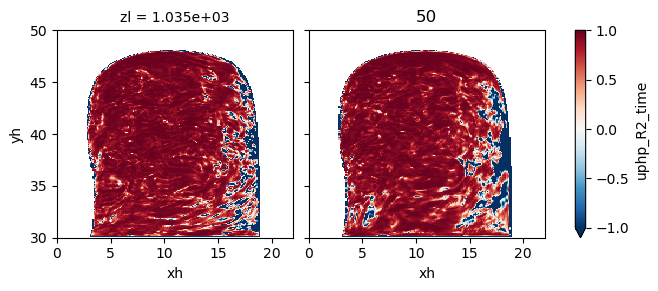

<Figure size 1200x550 with 0 Axes>

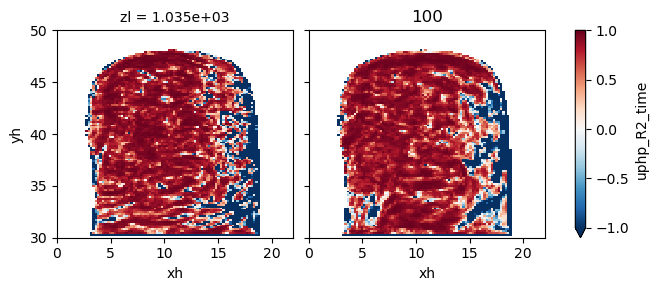

<Figure size 1200x550 with 0 Axes>

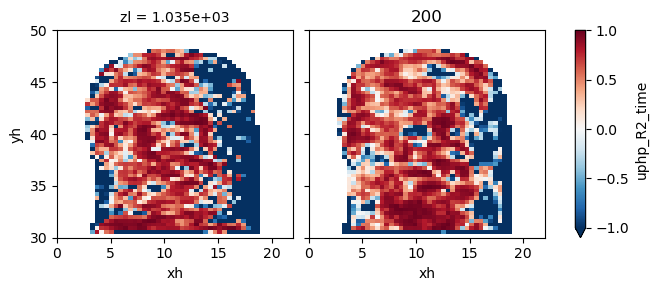

<Figure size 1200x550 with 0 Axes>

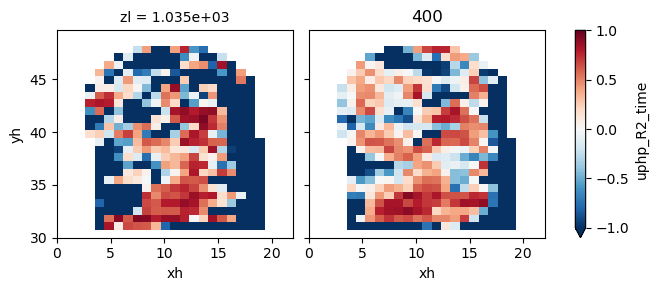

In [40]:
for scale in experiment_config_nondim['filter_scales']:

    plt.figure(figsize=(12, 5.5))

    test_eval_nondim.eval_datatree.ml_dataset[exp][scale].uphp_R2_time.plot(col='zl', vmax=1)
    plt.title(scale)

<Figure size 1200x550 with 0 Axes>

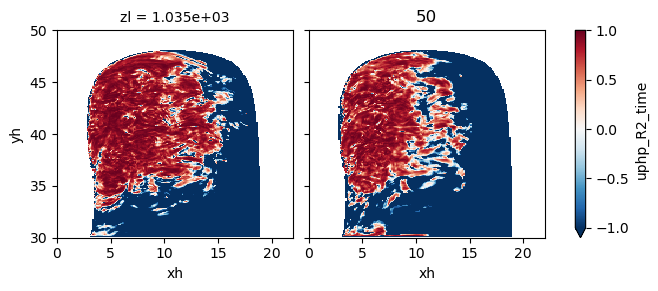

<Figure size 1200x550 with 0 Axes>

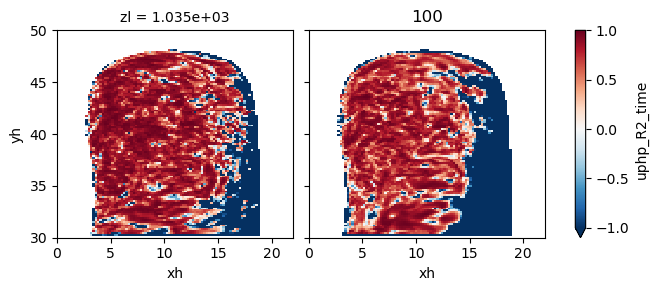

<Figure size 1200x550 with 0 Axes>

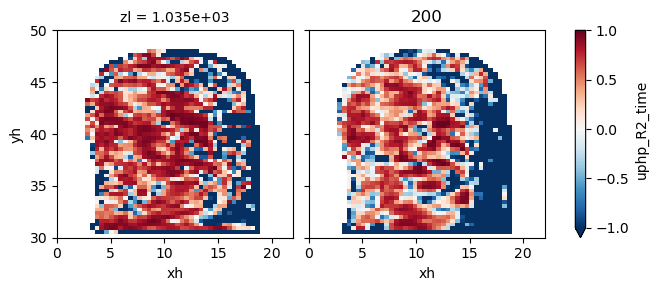

<Figure size 1200x550 with 0 Axes>

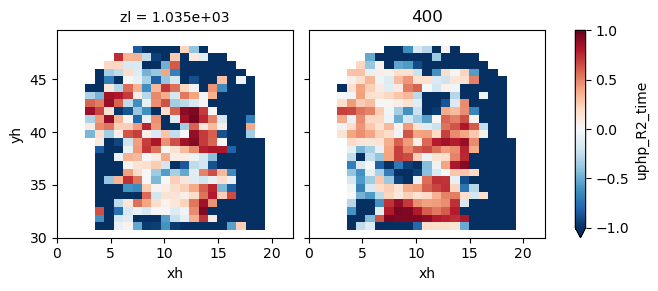

In [41]:
for scale in experiment_config_dim['filter_scales']:

    plt.figure(figsize=(12, 5.5))

    test_eval_dim.eval_datatree.ml_dataset[exp][scale].uphp_R2_time.plot(col='zl', vmax=1)
    plt.title(scale)